In [3]:
import csv
import requests
import time
from typing import List, Dict
import pandas as pd

In [4]:
data = pd.read_csv(r'C:\Users\mspreng\Dropbox\LBNL\Paper\Woodburn_GW\Table_S1_Watersheds.csv', index_col=0)

In [17]:
data

,River,Cntry.,Lat.,Lon.,Area (km^2)
ID,,,,,
1,AARE - Brienzwiler,CH,46.8,8.1,554
2,AARE - Brugg,CH,47.5,8.2,11750
3,AARE - Thun,CH,46.8,7.6,2490
4,ALLER - Rethem,DE,52.8,9.4,14728
5,Altamaha River At Everett City,US,31.4,-81.6,42022
...,...,...,...,...,...
256,Yangtse - Datong,CN,30.8,117.6,1705383
257,Yangtse - Xuliujing,CN,31.7,120.9,2307033
258,Yellowstone River Near Livingston,US,45.6,-110.6,9197


In [6]:
# import csv
# import requests
# import time
# from typing import List, Dict

def read_csv(filename: str) -> tuple[List[Dict], List[str]]:
    """Read CSV file and return data with fieldnames."""
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        fieldnames = reader.fieldnames
        data = list(reader)
    return data, fieldnames

def get_elevation_batch(coordinates: List[tuple]) -> List[float]:
    """
    Get elevations for a batch of coordinates using Open-Elevation API.
    coordinates: List of (lat, lon) tuples
    Returns: List of elevations in meters
    """
    # Open-Elevation API accepts POST requests with multiple locations
    locations = [{"latitude": lat, "longitude": lon} for lat, lon in coordinates]
    
    try:
        response = requests.post(
            'https://api.open-elevation.com/api/v1/lookup',
            json={"locations": locations},
            timeout=30
        )
        response.raise_for_status()
        results = response.json()
        return [result['elevation'] for result in results['results']]
    except Exception as e:
        print(f"Error fetching elevations: {e}")
        return [None] * len(coordinates)

def process_locations(input_file: str, output_file: str, lat_col: str = 'Lat', lon_col: str = 'Lon', batch_size: int = 100):
    """
    Process CSV file and add elevation data.
    
    Parameters:
    - input_file: Path to input CSV
    - output_file: Path to output CSV
    - lat_col: Name of latitude column (default: 'Lat')
    - lon_col: Name of longitude column (default: 'Lon')
    - batch_size: Number of locations to process per API call (default: 100)
    """
    print(f"Reading {input_file}...")
    data, fieldnames = read_csv(input_file)
    
    # Check if columns exist
    if lat_col not in fieldnames or lon_col not in fieldnames:
        print(f"Error: Could not find columns '{lat_col}' and/or '{lon_col}'")
        print(f"Available columns: {fieldnames}")
        return
    
    print(f"Found {len(data)} locations")
    
    # Add elevation column to fieldnames
    output_fieldnames = list(fieldnames) + ['Altitude_m']
    
    # Process in batches
    total = len(data)
    for i in range(0, total, batch_size):
        batch = data[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (total + batch_size - 1) // batch_size
        
        print(f"Processing batch {batch_num}/{total_batches} ({len(batch)} locations)...")
        
        # Extract coordinates
        coordinates = []
        for row in batch:
            try:
                lat = float(row[lat_col])
                lon = float(row[lon_col])
                coordinates.append((lat, lon))
            except (ValueError, KeyError) as e:
                print(f"Warning: Invalid coordinates in row: {row}")
                coordinates.append((None, None))
        
        # Get elevations
        elevations = get_elevation_batch(coordinates)
        
        # Add elevations to data
        for row, elevation in zip(batch, elevations):
            row['Altitude_m'] = elevation if elevation is not None else 'N/A'
        
        # Be respectful to the API - small delay between batches
        if i + batch_size < total:
            time.sleep(1)
    
    # Write output CSV
    print(f"Writing results to {output_file}...")
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=output_fieldnames)
        writer.writeheader()
        writer.writerows(data)
    
    print(f"Done! Processed {total} locations.")
    print(f"Results saved to {output_file}")


In [7]:

if __name__ == "__main__":
    # Configuration
    INPUT_FILE = r'C:\Users\mspreng\Dropbox\LBNL\Paper\Woodburn_GW\Table_S1_Watersheds.csv'  # Change this to your input file name
    OUTPUT_FILE = r'C:\Users\mspreng\Dropbox\LBNL\Paper\Woodburn_GW\Table_S1_Watersheds_alt.csv'  # Change this to your desired output name
    
    # If your CSV uses different column names, change these:
    LATITUDE_COLUMN = "Lat."
    LONGITUDE_COLUMN = "Lon."
    
    # Process the file
    process_locations(
        input_file=INPUT_FILE,
        output_file=OUTPUT_FILE,
        lat_col=LATITUDE_COLUMN,
        lon_col=LONGITUDE_COLUMN,
        batch_size=100
    )

Reading C:\Users\mspreng\Dropbox\LBNL\Paper\Woodburn_GW\Table_S1_Watersheds.csv...
Found 260 locations
Processing batch 1/3 (100 locations)...
Processing batch 2/3 (100 locations)...
Processing batch 3/3 (60 locations)...
Writing results to C:\Users\mspreng\Dropbox\LBNL\Paper\Woodburn_GW\Table_S1_Watersheds_alt.csv...
Done! Processed 260 locations.
Results saved to C:\Users\mspreng\Dropbox\LBNL\Paper\Woodburn_GW\Table_S1_Watersheds_alt.csv


In [9]:
data = pd.read_csv(OUTPUT_FILE, index_col=0)

In [10]:
data

,River,Cntry.,Lat.,Lon.,Area (km^2),Altitude_m
ID,,,,,,
1,AARE - Brienzwiler,CH,46.8,8.1,554,1805.0
2,AARE - Brugg,CH,47.5,8.2,11750,378.0
3,AARE - Thun,CH,46.8,7.6,2490,605.0
4,ALLER - Rethem,DE,52.8,9.4,14728,17.0
5,Altamaha River At Everett City,US,31.4,-81.6,42022,12.0
...,...,...,...,...,...,...
256,Yangtse - Datong,CN,30.8,117.6,1705383,7.0
257,Yangtse - Xuliujing,CN,31.7,120.9,2307033,5.0
258,Yellowstone River Near Livingston,US,45.6,-110.6,9197,1858.0


In [13]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of catchments')

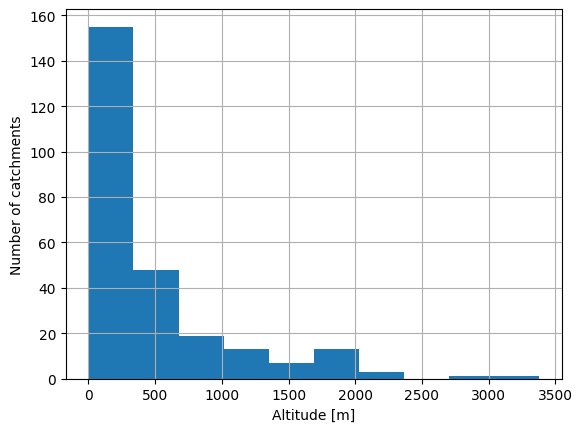

In [14]:
data.Altitude_m.hist()
# Add the x-axis label
plt.xlabel("Altitude [m]")

# Add a y-axis label and title for clarity (optional)
plt.ylabel("Number of catchments")

In [15]:
data[data.Altitude_m>2500]

,River,Cntry.,Lat.,Lon.,Area (km^2),Altitude_m
ID,,,,,,
82,Halfmoon Creek Near Malta,US,39.2,-106.4,61,2929.0
237,Vallecito Creek Near Bayfield,US,37.5,-107.5,188,3379.0
